# H2O-3

This notebook is intended to help you get started with distributed machine learning in the H2O AI Cloud using python.

* **Product Documentation:** https://docs.h2o.ai/h2o/latest-stable/h2o-docs/index.html
* **Python Documentation:** https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/index.html
* **Additional Tutorials:** https://github.com/h2oai/h2o-tutorials

## Prerequisites
This tutorial relies on the latest Steam SDK (1.8.11) which can be installed into a python environment by:

1. Click on My AI Engines from the H2O AI Cloud and then `Python client` to download the wheel file
2. Navigate to the location where the python client was downloaded and install the client using `pip install h2osteam-1.8.11-py2.py3-none-any.whl`

We require the `h2o_authn` library for securely connecting to the H2O AI Cloud platform: `pip install h2o_authn`.

We also set the following variables to connect to a specific H2O AI Cloud environment. They can be found by logging into the platform, clicking on your name, and choosing the `CLI & API Access` page. Then, copy values from the `Accessing H2O AI Cloud APIs` section.

In [2]:
CLIENT_ID = "q8s-internal-platform"
TOKEN_ENDPOINT = "https://auth.demo.h2o.ai/auth/realms/q8s-internal/protocol/openid-connect/token"
REFRESH_TOKEN = "https://cloud-internal.h2o.ai/auth/get-platform-token"

H2O_STEAM_URL = "https://steam.cloud-internal.h2o.ai/"

In [ ]:
from getpass import getpass

import h2o_authn
import h2osteam
from h2osteam.clients import H2oKubernetesClient

from h2o.estimators.glm import H2OGeneralizedLinearEstimator
import h2o

import pandas as pd
import numpy as np

## Securely connect to the platform
We first connect to the H2O AI Cloud using our personal access token to create a token provider object. We can then use this object to log into Steam and other APIs.

In [3]:
print(f"Visit {REFRESH_TOKEN} to get your personal access token")
tp = h2o_authn.TokenProvider(
    refresh_token=getpass("Enter your access token: "),
    client_id=CLIENT_ID,
    token_endpoint_url=TOKEN_ENDPOINT
)

Visit https://cloud-internal.h2o.ai/auth/get-platform-token to get your personal access token
Enter your access token: ········


Next, we will connect to our AI Engine manager to view all clusters of H2O-3 that we have access to. If you don't have a cluster of H2O-3 please view the Enterprise Steam tutorial. 

In [5]:
steam = h2osteam.login(
    url=H2O_STEAM_URL,
    access_token=tp()
)

## Connect to H2O-3
We will connect to a specific instance of H2O-3. This step will connect our imported `h2o` library which we can then use to interact with the cluster. 

We will also check if our local python package and the backend server have the same version numbers. 

In [9]:
for instance in steam.get_h2o_kubernetes_clusters():
    print(instance["id"], "\t", instance["profile_name"], "\t", instance["status"], "\t", instance["name"])

82 	 default-h2o-kubernetes 	 stopped 	 es-test-instance
83 	 default-h2o-kubernetes 	 stopped 	 es-test-instance-2
160 	 default-h2o-kubernetes 	 running 	 test-instance


In [10]:
cluster = H2oKubernetesClient().get_cluster(name="test-instance", created_by="michelle.tanco@h2o.ai")
cluster.connect()

Connecting to H2O server at https://steam.cloud-internal.h2o.ai:443/proxy/h2o-k8s/160 ... successful.


H2O_cluster_uptime:,1 min 57 secs
H2O_cluster_timezone:,Etc/GMT
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.0.3
H2O_cluster_version_age:,1 month and 28 days
H2O_cluster_name:,test-instance
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.185 Gb
H2O_cluster_total_cores:,1
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


## Data

We can create an H2O Dataframe object with data from our local machine or a URL. 

In [284]:
data = h2o.import_file("https://h2o-internal-release.s3-us-west-2.amazonaws.com/data/Splunk/churn.csv") 

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [285]:
data.shape

(3333, 21)

In [286]:
data.head()

State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10,3,2.7,1,False.
OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.7,1,False.
NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.3,162.6,104,7.32,12.2,5,3.29,0,False.
OH,84,408,375-9999,yes,no,0,299.4,71,50.9,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.
AL,118,510,391-8027,yes,no,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.7,0,False.
MA,121,510,355-9993,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,False.
MO,147,415,329-9001,yes,no,0,157,79,26.69,103.1,94,8.76,211.8,96,9.53,7.1,6,1.92,0,False.
LA,117,408,335-4719,no,no,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False.
WV,141,415,330-8173,yes,yes,37,258.6,84,43.96,222,111,18.87,326.4,97,14.69,11.2,5,3.02,0,False.


In [287]:
data.types

{'State': 'enum',
 'Account Length': 'int',
 'Area Code': 'int',
 'Phone': 'string',
 "Int'l Plan": 'enum',
 'VMail Plan': 'enum',
 'VMail Message': 'int',
 'Day Mins': 'real',
 'Day Calls': 'int',
 'Day Charge': 'real',
 'Eve Mins': 'real',
 'Eve Calls': 'int',
 'Eve Charge': 'real',
 'Night Mins': 'real',
 'Night Calls': 'int',
 'Night Charge': 'real',
 'Intl Mins': 'real',
 'Intl Calls': 'int',
 'Intl Charge': 'real',
 'CustServ Calls': 'int',
 'Churn?': 'enum'}

### Data Exploration

We can use H2O-3 to explore our dataset.  We can find correlations, build decision trees, and visualize our dataset.  In this demo, we will view the correlations and plot distributions.

We will first use H2O-3 to find the numeric columns that are correlated to Churn. 

In [288]:
numeric_cols = [k for k, v in data.types.items() if v in ['real', 'int']]
churn_cor_hf = data['Churn?'].cor(data[numeric_cols])
churn_cor_hf

Account Length,Area Code,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
0.0165407,0.00617423,-0.089728,0.205151,0.0184593,0.205151,0.0927958,0.00923313,0.092786,0.0354929,0.0061412,0.0354956,0.0682388,-0.0528443,0.0682586,0.20875


The result of the `cor` function is an H2O Frame with one row, showing the correlation of each variable to `Churn?`. Since this data is very small, we can convert it to a Pandas dataframe and order it based on absolute correlation.

In [289]:
churn_cor = churn_cor_hf.as_data_frame().transpose().reset_index()
churn_cor.columns = ['Feature', 'Correlation']
churn_cor = churn_cor.iloc[(-churn_cor['Correlation'].abs()).argsort()]
churn_cor.head()

,Feature,Correlation
15,CustServ Calls,0.208750
3,Day Mins,0.205151
5,Day Charge,0.205151
6,Eve Mins,0.092796
8,Eve Charge,0.092786


The greatest indicators of churn seem to be more calls to customer service as well as more calling minutes/charges.

We can use the histogram function to see the distribution of these top features.

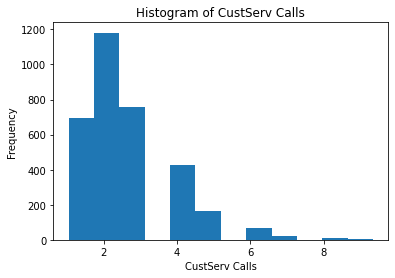

In [290]:
data['CustServ Calls'].hist();

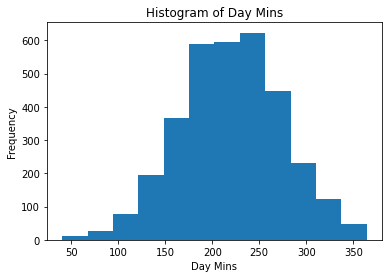

In [291]:
data['Day Mins'].hist();

### Split a Dataset

We will next split a dataset for training. When building models, we want to separate a section of data for validating how the model does.  This can be a good indicator of how well the model is at generalizing and predicting on unseen data.

We will use the split function to create a random split on the dataset.

In [292]:
splits = data.split_frame(ratios=[0.7, 0.15], seed=1)  

train = splits[0]
valid = splits[1]
test = splits[2]

### Prepare columns for training

In [293]:
y = 'Churn?'
x = [i for i in data.columns if i not in [y, 'Phone']] # remove columns

## Modeling

In this section, we will create models predicting Churn using H2O-3's algorithms.

### Baseline Model

We will start our modeling by building a baseline model.  This is a simple model that we will use as a control. In this example, we will build a Linear model to predict churn.

We first create an object of class, "H2OGeneralizedLinearEstimator". This does not actually do any training, it just sets the model up for training by specifying model parameters.

In [294]:
glm_fit1 = H2OGeneralizedLinearEstimator(model_id='glm_fit1',
                                         ## fix a random number generator seed for reproducibility
                                         seed=1234,
                                         
                                         ## predict a yes/no column
                                         family='binomial',
                                         
                                         ## cross validation
                                         nfolds=3, 
                                         
                                         ## use cross validation to find the best regularization
                                         lambda_search=True 
                                        )

Now that `glm_fit1` object is initialized, we can train the model:

In [295]:
glm_fit1.train(x = x, y = y, training_frame = train, validation_frame = valid);

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


The plot below shows the objective loss function as each iteration of the model is trained.

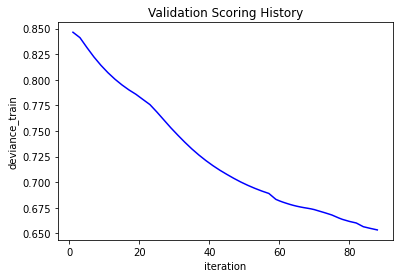

In [296]:
glm_fit1.plot();

#### Explore predictions

Let's see the performance of the GLM that were just trained. 

In [297]:
glm_perf1 = glm_fit1.model_performance(test)

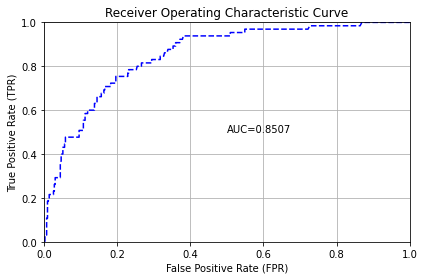

In [298]:
glm_perf1.plot();

We can see the AUC on the training dataset compared with the validation dataset.  The linear model is slighly better at predicting on the training dataset.  This is to be expected since the training data was seen by the model.

In [299]:
print ("AUC on Training Data: {0:.3f}".format(glm_fit1.auc(train = True)))
print ("AUC on Validation Data: {0:.3f}".format(glm_fit1.auc(valid = True)))

AUC on Training Data: 0.825
AUC on Validation Data: 0.817


Here are the predictions on the validation dataset.

In [300]:
glm_preds = glm_fit1.predict(valid)
glm_preds.head()

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict,False.,True.
False.,0.929233,0.0707669
True.,0.472975,0.527025
True.,0.738794,0.261206
False.,0.838432,0.161568
False.,0.967323,0.0326771
False.,0.950756,0.0492442
False.,0.852221,0.147779
False.,0.958568,0.0414322
False.,0.912917,0.0870831
False.,0.974215,0.0257855


Since our model is a GLM model, we can also see the coefficients of each variable. The plot below shows that `Int'l Plan=Yes` increases the likelihood of churn.

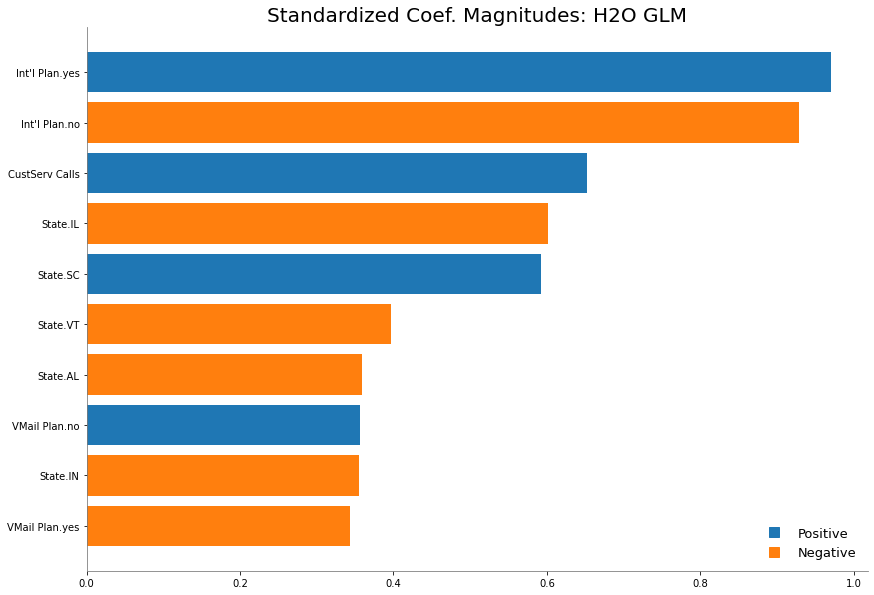

In [301]:
glm_fit1.std_coef_plot(num_of_features=10)

### Non Linear Model

Now we will train a non-linear model to compare to our baseline model.  Non-linear models are more complex and can have higher accuracy.  We will build an XGBoost model which will train a series of decision trees, each on the error of the previous one, as a way to self correct the model's predictions.

In [302]:
from h2o.estimators.xgboost import H2OXGBoostEstimator

xgboost_fit1 = H2OXGBoostEstimator(model_id='xgboost_fit1',
                                   
                                   ## fix a random number generator seed for reproducibility
                                   seed=1234,
                                   
                                   ## cross validation
                                   nfolds=3,
                                   
                                   ## more trees is better if the learning rate is small enough 
                                   ## here, use "more than enough" trees - we have early stopping
                                   ntrees=1000, 
                                   
                                   ## early stopping once the validation AUC doesn't improve by at least 0.01% for 5 consecutive scoring events
                                   stopping_rounds = 5, stopping_tolerance = 1e-4, stopping_metric = "AUC", 
                                   
                                   ## score every 10 trees to make early stopping reproducible (it depends on the scoring interval)
                                   score_tree_interval = 10,
                                   
                                   ## sample 80% of rows per tree
                                   sample_rate = 0.8,                                                       
                                   ## sample 80% of columns per split
                                   col_sample_rate = 0.8,     
                                   
                                  )
xgboost_fit1.train(x = x, y = y, training_frame = train, validation_frame = valid);

xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%


The plot below shows the objective loss function as the more trees are trained.

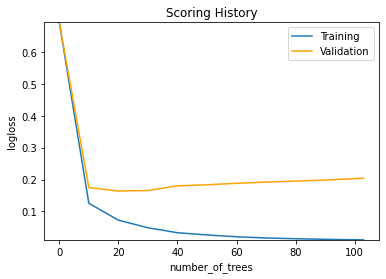

In [303]:
xgboost_fit1.plot();

### Explore Predictions

We can view the predictions from the XGBoost model and compare them with our GLM model.

In [304]:
print ("GLM AUC on Test: {0:.3f}".format(glm_fit1.auc(valid = True)))
print ("XGBoost AUC on Test: {0:.3f}".format(xgboost_fit1.auc(valid = True)))

GLM AUC on Test: 0.817
XGBoost AUC on Test: 0.887


We can see that our XGBoost model does significantly better predicting on the validation dataset.

Although the XGBoost has higher accuracy, it is less interpretable.  In the linear model, we were able to see the coefficient associated to each variable. The coefficient shows us how the variable changes the prediction (in what direction and by how much).  
For a non-linear model, we can see the Variable Importance (the importance of the variable to the model) but we do not see the direction.  This is because non-linear models do not have one clear direction associated to each variable.

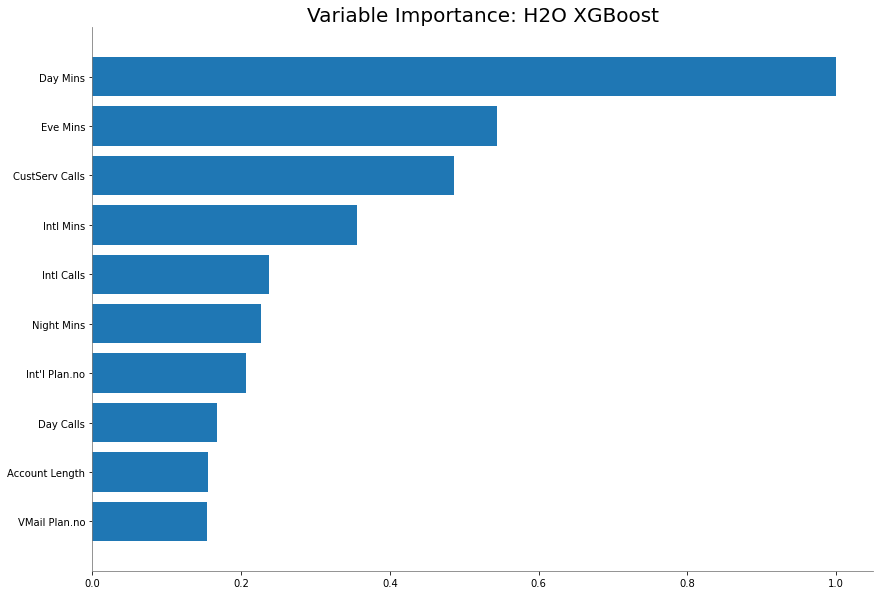

<Figure size 432x288 with 0 Axes>

In [305]:
xgboost_fit1.varimp_plot();

The variable importance shows us that `Day Mins` has the biggest impact on the model's predictions but we do not know if more minutes increases or decreases the prediction (or both).  We can use partial dependence plots to learn more about the relationship between `Day Mins` and the prediction.

The partial dependence plot below shows the average prediction if all records had a specific `Day Mins` value set.

PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%


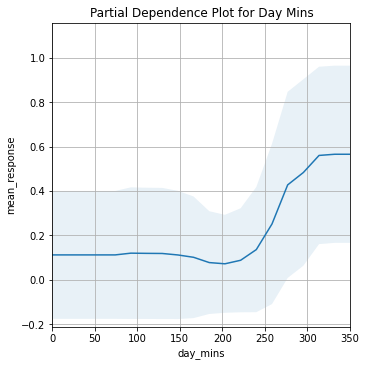

In [306]:
xgboost_fit1.partial_plot(data=train, cols=['Day Mins'], figsize=(5, 5));

The plot shows us that if the minutes per day is more than 200, the likelihood of churn spikes.  Below is the same graph for our linear model.  The linear model does not capture this nuance and instead steadily increases the likelihood of churn the more minutes are used per day.

PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%


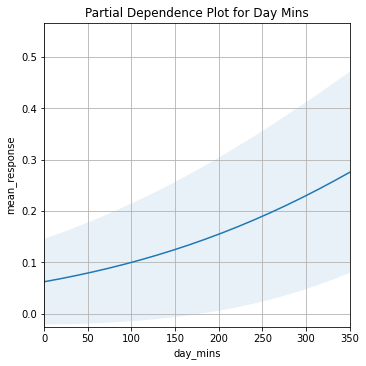

In [307]:
glm_fit1.partial_plot(data=train, cols=['Day Mins'], figsize=(5, 5));

The partial dependence plot shows us a high level overview of how the features effect the predictions but we can use Shapley reason codes to learn the reasons behind the prediction for an individual customer.

The `predict_contributions` function gives us the influence the variables have on the individual prediction.

In [308]:
xgboost_fit1.predict_contributions(test)

contributions progress: |████████████████████████████████████████████████████████| (done) 100%


State.AK,State.AL,State.AR,State.AZ,State.CA,State.CO,State.CT,State.DC,State.DE,State.FL,State.GA,State.HI,State.IA,State.ID,State.IL,State.IN,State.KS,State.KY,State.LA,State.MA,State.MD,State.ME,State.MI,State.MN,State.MO,State.MS,State.MT,State.NC,State.ND,State.NE,State.NH,State.NJ,State.NM,State.NV,State.NY,State.OH,State.OK,State.OR,State.PA,State.RI,State.SC,State.SD,State.TN,State.TX,State.UT,State.VA,State.VT,State.WA,State.WI,State.WV,State.WY,State.missing(NA),Int'l Plan.no,Int'l Plan.yes,Int'l Plan.missing(NA),VMail Plan.no,VMail Plan.yes,VMail Plan.missing(NA),Account Length,Area Code,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,BiasTerm
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00160877,0,-0.00521609,0,0,-0.00813922,0,0,0,0,0,-0.000830525,0,0,0,0,0,-0.0220484,0,0.000311738,0,-0.00236507,0,0,0,0,-0.00909333,0,0,-0.0175029,0,0,-0.000304467,0,0,0,0,0,1.6071,0.508415,0,-1.84297,-0.366472,0,-0.107807,-0.0515849,-0.076778,1.83979,-0.255898,0.321007,-0.257748,0.371351,0.0635999,0.118864,-0.306028,0.206007,-1.03806,-0.911412,-0.101332,-0.29613,-2.03826
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00190977,0,-0.000725611,0,0,-0.00726218,0,0,0,0,0,-0.00295724,0,0,0,0,0,-0.0356442,0,0.000549845,0,-0.00389249,0,0,0,0,-0.011491,0,0,-0.0225596,0,0,-0.000718896,0,0,0,0,0,-0.181164,-0.0478081,0,0.331376,0.0301257,0,0.959924,-0.0534586,-0.0920808,-1.22828,0.0969159,-0.298716,-0.318924,-0.273124,0.0322441,0.216569,0.413382,-0.0143522,0.0631701,-0.233753,0.0450274,-0.69622,-2.03826
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00199412,0,-0.000725611,0,0,-0.0102929,0,0,0,0,0,-0.00295724,0,0,0,0,0,1.4865,0,0.000549845,0,-0.00389249,0,0,0,0,-0.012318,0,0,-0.0191942,0,0,-0.000718896,0,0,0,0,0,-0.202766,-0.061399,0,0.217401,0.0286241,0,0.170016,0.188343,-0.137423,-1.82649,-0.592009,-0.423901,0.54431,-0.33738,-0.0415453,-0.333679,-0.287785,-0.0337795,-0.493256,-0.78789,-0.0403629,-0.776691,-2.03826
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00516976,0,-0.00108383,0,0,-0.00521204,0,0,0,0,0,-0.00295724,0,0,0,0,0,-0.0311096,0,0.000549845,0,-0.00620884,0,0,0,0,-0.00796483,0,0,-0.02247,0,0,-0.00276755,0,0,0,0,0,-0.185451,-0.0545511,0,0.366118,0.0424066,0,-0.580949,0.0704298,-0.124675,-0.948801,0.124312,-0.16598,-0.424244,-0.0746007,-0.0280849,1.00407,-0.104352,0.185818,-0.475093,-0.00433016,-0.0061563,-0.364763,-2.03826
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00424254,0,-0.000725611,0,0,-0.0096284,0,0,0,0,0,-0.00295724,0,0,0,0,0,-0.030375,0,0.000549845,0,-0.0059725,0,0,0,0,-0.0062352,0,0,-0.02104,0,0,-0.00276755,0,0,0,0,0,-0.249452,-0.0494407,0,0.351838,0.0371452,0,0.136133,0.286752,-0.100869,-1.89874,0.441675,-0.489898,0.441544,-0.14756,0.0143329,0.863279,-0.667601,-0.063913,0.348016,0.189689,0.0858615,-0.508737,-2.03826
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00424254,0,-0.00133052,0,0,-0.00892485,0,0,0,0,0,-0.00295724,0,0,0,0,0,-0.0257391,0,0.000222654,0,-0.00313455,0,0,0,0,-0.00871411,0,0,-0.0229745,0,0,-0.000718896,0,0,0,0,0,-0.312961,-0.0569815,0,-0.889381,-0.081788,0,0.0474402,0.408067,0.106832,-0.486547,-0.0503523,-0.275402,-0.26225,0.0917209,-0.0615442,-0.0135984,-0.247317,-0.0764496,-0.773804,0.151141,-0.0474799,-0.242149,-2.03826
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00516976,0,-0.00133052,0,0,-0.0112154,0,0,0,0,0,-0.00295724,0,0,0,0,0,-0.0221901,0,0.000300575,0,-0.00539708,0,0,0,0,-0.00888728,0,0,-0.0125892,0,0,-0.00276755,0,0,0,0,0,-0.242807,-0.0417324,0,0.0958755,0.0203812,0,-0.384425,0.271506,-0.193132,-0.0430757,-0.499252,-0.109528,-0.573957,-0.554095,-0.237074,-0.325841,-0.352092,0.0215569,0.0916829,-0.342344,0.0857758,-0.993604,-2.03826
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00424254,0,-0.00835957,0,0,-0.0108999,0,0,0,0,0,-0.00131313,0,0,0,0,0,-0.0161922,0,0.000300575,0,-0.00657591,0,0,0,0,-0.0106826,0,0,-0.0131283,0,0,-0.000420303,0,0,0,0,0,-0.267979,-0.0405098,0,0.291113,0.0387266,0,0.180821,-0.20703,-0.145184,0.251869,-0.43028,0.0888506,-2.146,-0.109533,-0.265106,-0.490008,-0.236488,0.0826315,-0.5427

### AutoML

We will now automate the machine learning process using AutoML and the `explain` function.  AutoML will automatically tune models and try out different algorithms for the user and provide a leaderboard. 

In [309]:
from h2o.automl import H2OAutoML

aml = H2OAutoML(## train up to 10 models
                max_models=10, 
    
                ## set seed for reproducibility
                seed=1234,
                
                ## option to exclude specific algorithms
                exclude_algos=['StackedEnsemble', 'DeepLearning']
                )
aml.train(x=x, y=y, training_frame=train, leaderboard_frame=valid);

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


The leaderboard belows shows us the AUC of each model on our `valid` data.  The best model is a Random Forest model.

In [310]:
aml.leaderboard

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
DRF_1_AutoML_6_20220418_103005,0.906057,0.258968,0.820855,0.104798,0.223183,0.0498106
GBM_3_AutoML_6_20220418_103005,0.90525,0.184631,0.817246,0.15846,0.213522,0.0455917
XGBoost_3_AutoML_6_20220418_103005,0.902585,0.162239,0.856828,0.104272,0.189099,0.0357583
XGBoost_2_AutoML_6_20220418_103005,0.901848,0.179839,0.846374,0.121738,0.206006,0.0424386
XRT_1_AutoML_6_20220418_103005,0.898008,0.208259,0.842302,0.13226,0.227589,0.051797
GBM_4_AutoML_6_20220418_103005,0.891362,0.186292,0.818684,0.156145,0.211062,0.0445474
GBM_2_AutoML_6_20220418_103005,0.88454,0.191372,0.808828,0.135732,0.211719,0.0448249
GBM_1_AutoML_6_20220418_103005,0.883926,0.239165,0.72398,0.127946,0.256061,0.0655672
XGBoost_1_AutoML_6_20220418_103005,0.883523,0.204895,0.813781,0.128683,0.224168,0.0502512
GLM_1_AutoML_6_20220418_103005,0.817796,0.309194,0.459268,0.261258,0.302586,0.0915581


In [311]:
aml.leader

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_1_AutoML_6_20220418_103005


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,47.0,47.0,95694.0,14.0,20.0,17.06383,99.0,197.0,143.76596




ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.05953627294656597
RMSE: 0.2440005593160925
LogLoss: 0.5975889950277231
Mean Per-Class Error: 0.14676222019186844
AUC: 0.9031071550936501
AUCPR: 0.8112223659161533
Gini: 0.8062143101873003

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3913043478260869: 


,,False.,True.,Error,Rate
0,False.,1926.0,64.0,0.0322,(64.0/1990.0)
1,True.,92.0,260.0,0.2614,(92.0/352.0)
2,Total,2018.0,324.0,0.0666,(156.0/2342.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.391304,0.769231,93.0
1,max f2,0.272727,0.783460,115.0
2,max f0point5,0.518519,0.824627,74.0
3,max accuracy,0.450000,0.935952,84.0
4,max precision,1.000000,1.000000,0.0
5,max recall,0.000000,1.000000,173.0
6,max specificity,1.000000,1.000000,0.0
7,max absolute_mcc,0.437500,0.735374,86.0
8,max min_per_class_accuracy,0.176471,0.857955,134.0
9,max mean_per_class_accuracy,0.272727,0.873413,115.0



Gains/Lift Table: Avg response rate: 15.03 %, avg score: 14.87 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010675,0.909091,6.653409,6.653409,1.000000,0.950029,1.000000,0.950029,0.071023,0.071023,565.340909,565.340909,0.071023
1,2,0.020068,0.819144,6.350981,6.511847,0.954545,0.855186,0.978723,0.905634,0.059659,0.130682,535.098140,551.184720,0.130179
2,3,0.030316,0.768190,6.376184,6.465989,0.958333,0.792432,0.971831,0.867369,0.065341,0.196023,537.618371,546.598912,0.195018
3,4,0.040564,0.736842,5.821733,6.303230,0.875000,0.752540,0.947368,0.838359,0.059659,0.255682,482.173295,530.322967,0.253169
4,5,0.050811,0.714286,6.098958,6.262032,0.916667,0.724785,0.941176,0.815454,0.062500,0.318182,509.895833,526.203209,0.314664
5,6,0.102477,0.529412,5.663646,5.960346,0.851240,0.618049,0.895833,0.715929,0.292614,0.610795,466.364576,496.034564,0.598233
6,7,0.151580,0.350000,3.066354,5.022855,0.460870,0.432955,0.754930,0.624261,0.150568,0.761364,206.635375,402.285531,0.717645
7,8,0.200683,0.235294,1.446393,4.147764,0.217391,0.286871,0.623404,0.541708,0.071023,0.832386,44.639328,314.776354,0.743442
8,9,0.303587,0.133333,0.441720,2.891566,0.066390,0.170050,0.434599,0.415731,0.045455,0.877841,-55.827989,189.156598,0.675831
9,10,0.400512,0.083333,0.087931,2.213074,0.013216,0.105608,0.332623,0.340680,0.008523,0.886364,-91.206948,121.307424,0.571791




ModelMetricsBinomial: drf
** Reported on cross-validation data. **

MSE: 0.059862150259661254
RMSE: 0.2446674278682417
LogLoss: 0.37786811695628375
Mean Per-Class Error: 0.12663459342165373
AUC: 0.9126341936957515
AUCPR: 0.8328342664358555
Gini: 0.825268387391503

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33999999999999997: 


,,False.,True.,Error,Rate
0,False.,1910.0,80.0,0.0402,(80.0/1990.0)
1,True.,75.0,277.0,0.2131,(75.0/352.0)
2,Total,1985.0,357.0,0.0662,(155.0/2342.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.340000,0.781382,50.0
1,max f2,0.240000,0.795091,58.0
2,max f0point5,0.542857,0.824653,33.0
3,max accuracy,0.420000,0.936806,44.0
4,max precision,1.000000,1.000000,0.0
5,max recall,0.000000,1.000000,83.0
6,max specificity,1.000000,1.000000,0.0
7,max absolute_mcc,0.340000,0.742416,50.0
8,max min_per_class_accuracy,0.200000,0.855114,61.0
9,max mean_per_class_accuracy,0.240000,0.881084,58.0



Gains/Lift Table: Avg response rate: 15.03 %, avg score: 14.67 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.011956,0.820000,6.653409,6.653409,1.000000,0.878265,1.000000,0.878265,0.079545,0.079545,565.340909,565.340909,0.079545
1,2,0.020922,0.771429,6.653409,6.653409,1.000000,0.785034,1.000000,0.838309,0.059659,0.139205,565.340909,565.340909,0.139205
2,3,0.030743,0.740000,6.653409,6.653409,1.000000,0.749814,1.000000,0.810040,0.065341,0.204545,565.340909,565.340909,0.204545
3,4,0.040564,0.685714,6.653409,6.653409,1.000000,0.707081,1.000000,0.785113,0.065341,0.269886,565.340909,565.340909,0.269886
4,5,0.050811,0.657143,6.653409,6.653409,1.000000,0.666726,1.000000,0.761236,0.068182,0.338068,565.340909,565.340909,0.338068
5,6,0.102050,0.500000,5.267282,5.957446,0.791667,0.570952,0.895397,0.665696,0.269886,0.607955,426.728220,495.744580,0.595392
6,7,0.152434,0.340000,3.552244,5.162449,0.533898,0.405835,0.775910,0.579804,0.178977,0.786932,255.224384,416.244907,0.746731
7,8,0.204526,0.228571,1.199795,4.153172,0.180328,0.265269,0.624217,0.499693,0.062500,0.849432,19.979508,315.317185,0.758980
8,9,0.335611,0.120000,0.216723,2.615653,0.032573,0.153723,0.393130,0.364562,0.028409,0.877841,-78.327658,161.565319,0.638142
9,10,0.403928,0.085714,0.124751,2.194359,0.018750,0.098063,0.329810,0.319488,0.008523,0.886364,-87.524858,119.435902,0.567771




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.939375,0.012468,0.927505,0.936034,0.942308,0.931624,0.959402
1,auc,0.914053,0.012275,0.904151,0.910933,0.930404,0.901852,0.922923
2,err,0.060625,0.012468,0.072495,0.063966,0.057692,0.068376,0.040598
3,err_count,28.400000,5.856620,34.000000,30.000000,27.000000,32.000000,19.000000
4,f0point5,0.805440,0.051524,0.803357,0.784314,0.803571,0.747801,0.888158
5,f1,0.794222,0.036522,0.797619,0.761905,0.800000,0.761194,0.850394
6,f2,0.783990,0.028174,0.791962,0.740741,0.796460,0.775076,0.815710
7,lift_top_group,6.717683,0.685162,5.517647,7.106060,6.882353,7.200000,6.882353
8,logloss,0.377871,0.110400,0.458918,0.290324,0.266969,0.349027,0.524117
9,max_per_class_error,0.222328,0.028464,0.211765,0.272727,0.205882,0.215385,0.205882



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2022-04-18 10:30:12,0.588 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,,2022-04-18 10:30:12,0.616 sec,5.0,0.329812,2.809776,0.790454,0.503068,4.365200,0.143269
2,,2022-04-18 10:30:12,0.643 sec,10.0,0.288060,1.477896,0.851494,0.625657,5.153131,0.104922
3,,2022-04-18 10:30:12,0.670 sec,15.0,0.270224,1.027059,0.869587,0.718895,6.228723,0.090248
4,,2022-04-18 10:30:12,0.704 sec,20.0,0.259864,0.826319,0.886122,0.760556,6.438783,0.078138
5,,2022-04-18 10:30:12,0.733 sec,25.0,0.253988,0.740163,0.894456,0.779067,6.376184,0.070453
6,,2022-04-18 10:30:12,0.760 sec,30.0,0.249573,0.682002,0.900146,0.802311,6.653409,0.067464
7,,2022-04-18 10:30:12,0.789 sec,35.0,0.246507,0.679154,0.900795,0.809512,6.653409,0.063621
8,,2022-04-18 10:30:12,0.819 sec,40.0,0.245098,0.624245,0.903964,0.811818,6.653409,0.066183
9,,2022-04-18 10:30:12,0.850 sec,45.0,0.244336,0.610824,0.903109,0.810789,6.653409,0.064902



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,State,1440.955811,1.000000,0.156913
1,Day Charge,1146.153442,0.795412,0.124810
2,CustServ Calls,1139.085938,0.790507,0.124041
3,Day Mins,1011.792480,0.702168,0.110179
4,Int'l Plan,726.270203,0.504020,0.079087
5,Intl Calls,477.271942,0.331219,0.051972
6,Eve Charge,439.792206,0.305209,0.047891
7,Eve Mins,420.048340,0.291507,0.045741
8,Intl Charge,355.151031,0.246469,0.038674
9,Intl Mins,279.724579,0.194124,0.030461


We can examine the model automatically by calling the explain function.  The explain function returns performance metrics, comparison between the models, and explains the best model.

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
DRF_1_AutoML_6_20220418_103005,0.906057,0.258968,0.820855,0.104798,0.223183,0.0498106,279,0.010498,DRF
GBM_3_AutoML_6_20220418_103005,0.90525,0.184631,0.817246,0.15846,0.213522,0.0455917,278,0.011033,GBM
XGBoost_3_AutoML_6_20220418_103005,0.902585,0.162239,0.856828,0.104272,0.189099,0.0357583,285,0.010147,XGBoost
XGBoost_2_AutoML_6_20220418_103005,0.901848,0.179839,0.846374,0.121738,0.206006,0.0424386,401,0.010501,XGBoost
XRT_1_AutoML_6_20220418_103005,0.898008,0.208259,0.842302,0.13226,0.227589,0.051797,330,0.01293,DRF
GBM_4_AutoML_6_20220418_103005,0.891362,0.186292,0.818684,0.156145,0.211062,0.0445474,276,0.011505,GBM
GBM_2_AutoML_6_20220418_103005,0.88454,0.191372,0.808828,0.135732,0.211719,0.0448249,282,0.012171,GBM
GBM_1_AutoML_6_20220418_103005,0.883926,0.239165,0.72398,0.127946,0.256061,0.0655672,226,0.058744,GBM
XGBoost_1_AutoML_6_20220418_103005,0.883523,0.204895,0.813781,0.128683,0.224168,0.0502512,377,0.010582,XGBoost
GLM_1_AutoML_6_20220418_103005,0.817796,0.309194,0.459268,0.261258,0.302586,0.0915581,157,0.01064,GLM


# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## DRF_1_AutoML_6_20220418_103005


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4893617021276596: 


,,False.,True.,Error,Rate
0,False.,1990.0,0.0,0.0,(0.0/1990.0)
1,True.,0.0,352.0,0.0,(0.0/352.0)
2,Total,1990.0,352.0,0.0,(0.0/2342.0)


# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

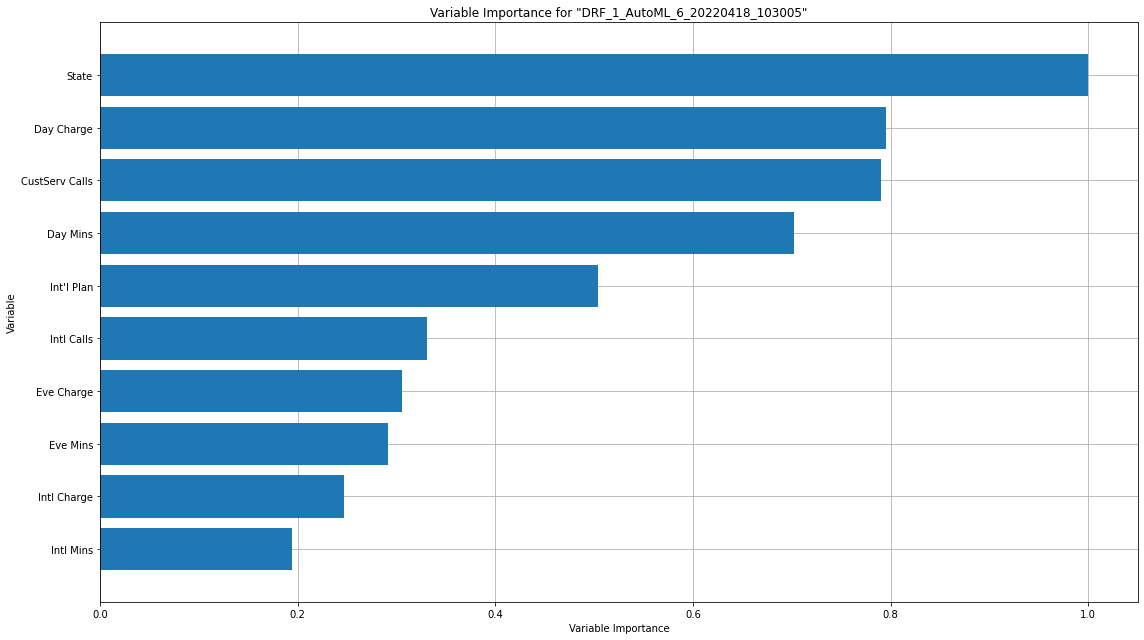

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

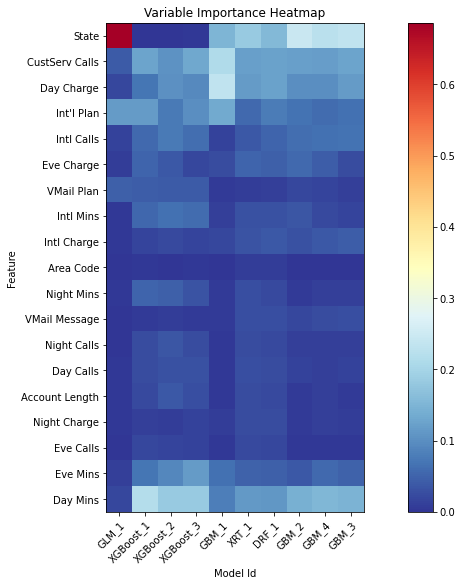

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

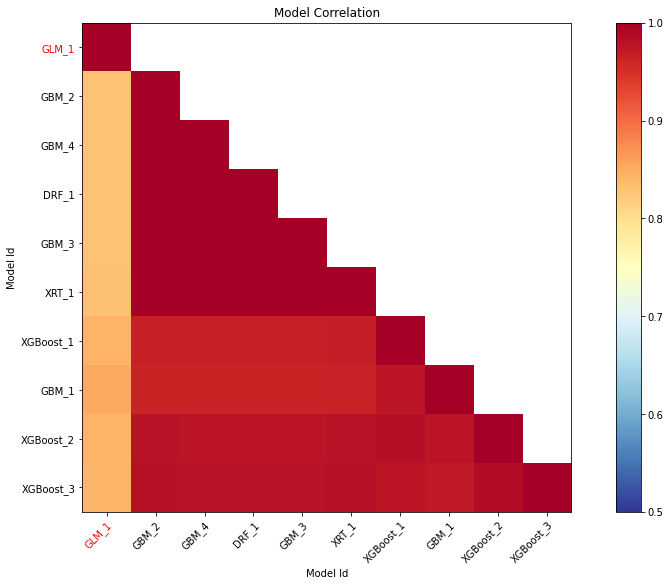

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

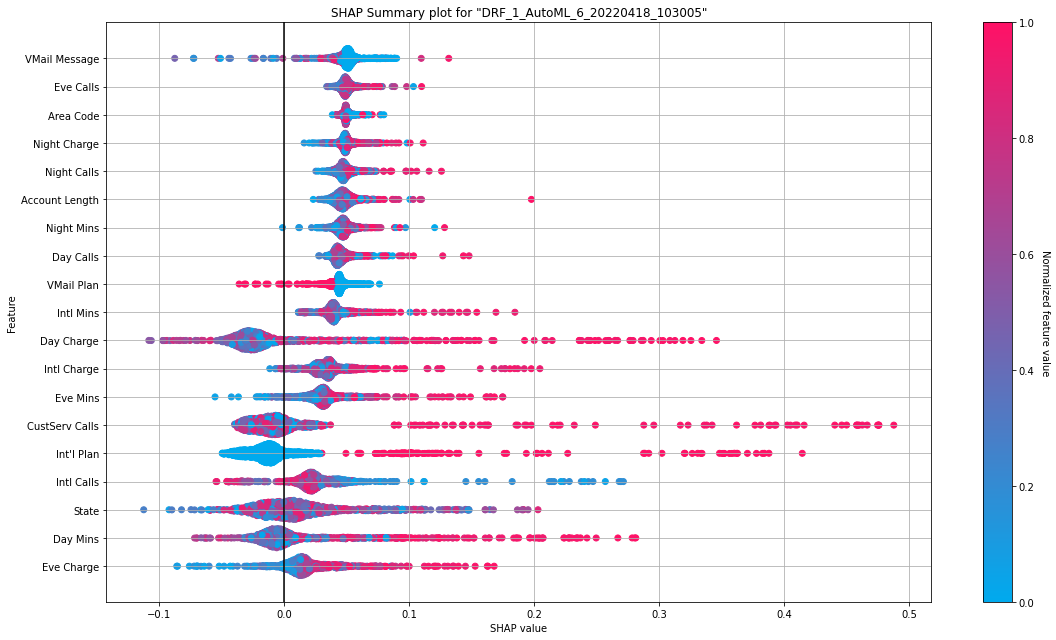

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

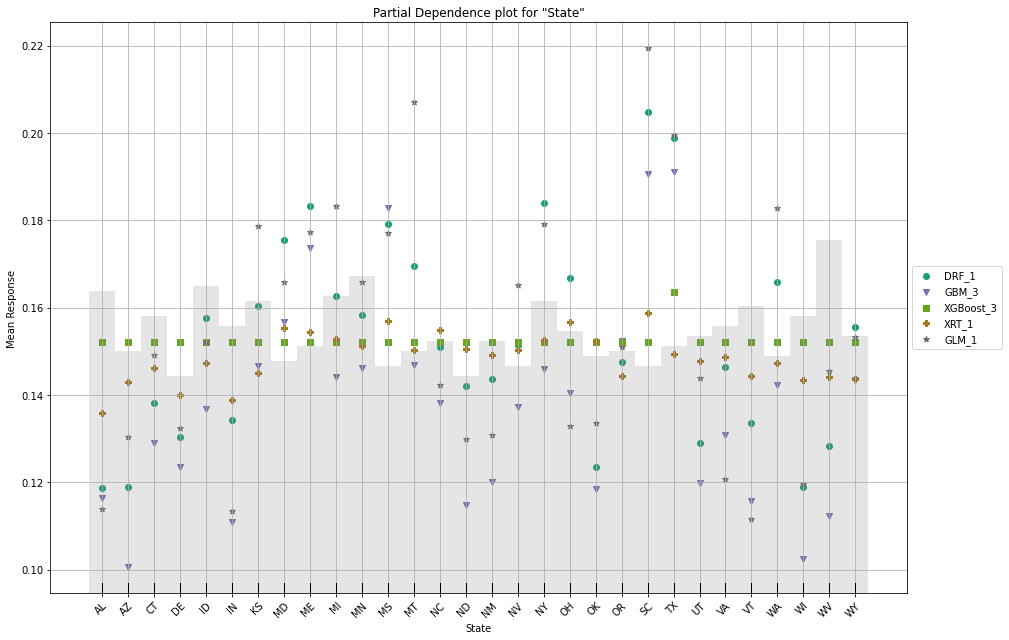

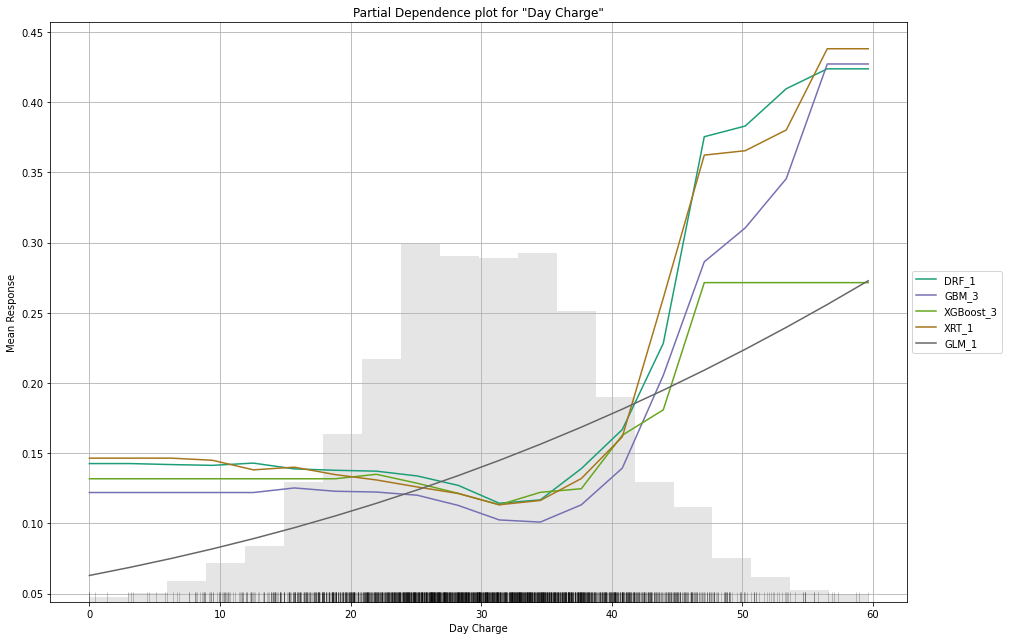

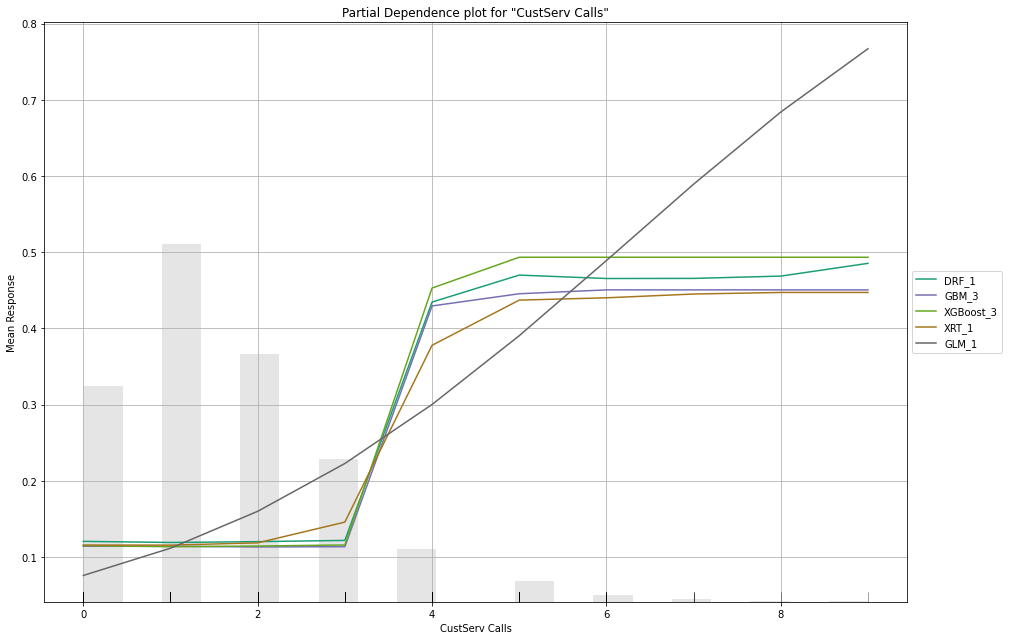

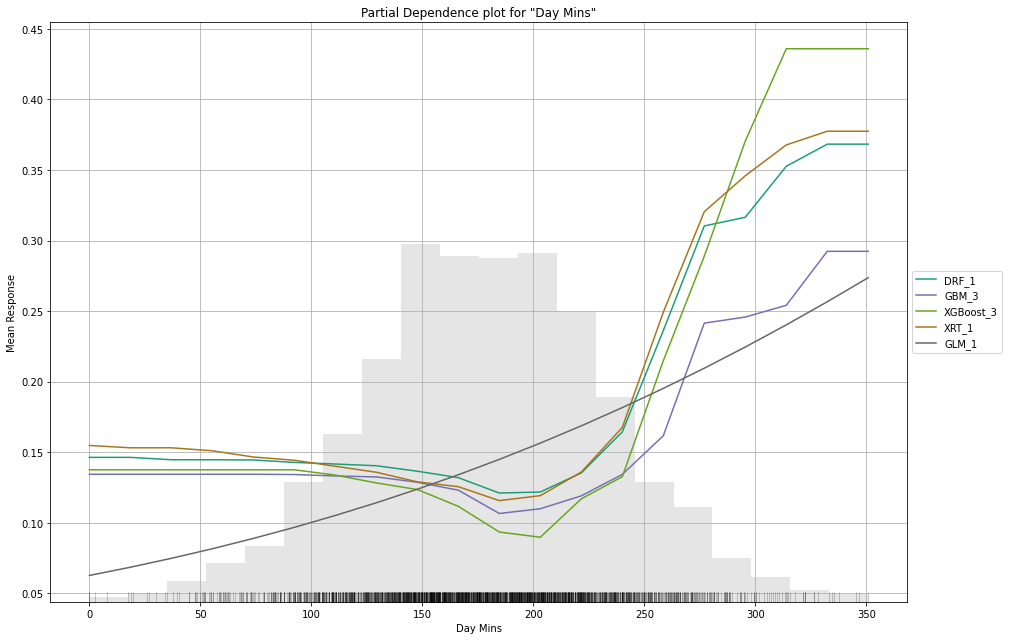

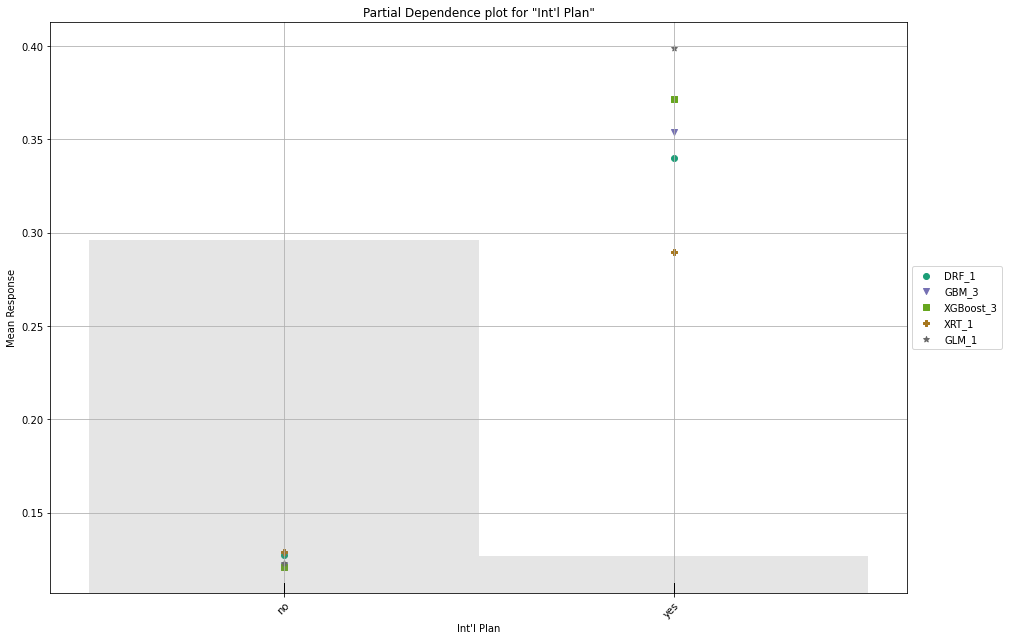

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
DRF_1_AutoML_6_20220418_103005,0.906057,0.258968,0.820855,0.104798,0.223183,0.0498106,279,0.010498,DRF
GBM_3_AutoML_6_20220418_103005,0.90525,0.184631,0.817246,0.15846,0.213522,0.0455917,278,0.011033,GBM
XGBoost_3_AutoML_6_20220418_103005,0.902585,0.162239,0.856828,0.104272,0.189099,0.0357583,285,0.010147,XGBoost
XGBoost_2_AutoML_6_20220418_103005,0.901848,0.179839,0.846374,0.121738,0.206006,0.0424386,401,0.010501,XGBoost
XRT_1_AutoML_6_20220418_103005,0.898008,0.208259,0.842302,0.13226,0.227589,0.051797,330,0.01293,DRF
GBM_4_AutoML_6_20220418_103005,0.891362,0.186292,0.818684,0.156145,0.211062,0.0445474,276,0.011505,GBM
GBM_2_AutoML_6_20220418_103005,0.88454,0.191372,0.808828,0.135732,0.211719,0.0448249,282,0.012171,GBM
GBM_1_AutoML_6_20220418_103005,0.883926,0.239165,0.72398,0.127946,0.256061,0.0655672,226,0.058744,GBM
XGBoost_1_AutoML_6_20220418_103005,0.883523,0.204895,0.813781,0.128683,0.224168,0.0502512,377,0.010582,XGBoost
GLM_1_AutoML_6_20220418_103005,0.817796,0.309194,0.459268,0.261258,0.302586,0.0915581,157,0.01064,GLM


# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## DRF_1_AutoML_6_20220418_103005


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4893617021276596: 


,,False.,True.,Error,Rate
0,False.,1990.0,0.0,0.0,(0.0/1990.0)
1,True.,0.0,352.0,0.0,(0.0/352.0)
2,Total,1990.0,352.0,0.0,(0.0/2342.0)


# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

In [312]:
aml.explain(train)

We can download the Model Deployment Object (the MOJO) for easy deployment in MLOps.

In [ ]:
aml.leader.download_mojo()